# Now that we can find the star position, let's test PSF interpolation

Simple interpolation shift to match the positions, and then scale and subtract

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
# import pyklip

In [3]:
from astropy import stats

from astropy.io import fits
from astropy import units

In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt

In [5]:
from scipy import interpolate
from scipy import optimize

In [6]:
from coronspec_tools import utils as ctutils
from coronspec_tools import misc as ctmisc
from coronspec_tools import observing_sequence, sdi_tools, interp_psf
import agplot

In [7]:
agplot.styles.notebook_style()

In [8]:
# data_files = sorted(Path("/Volumes/agdisk/hst_17092_data/MAST_2025-04-09T1710/HST/").glob("of*/*fits"))
data_files = sorted(Path("../../data/MAST_2024-03-21T13_06_42.642Z/MAST_2024-03-21T13_06_42.642Z/HST/").glob("OF*/*fits"))

In [9]:
len(data_files)

38

In [10]:
file_managers = {}
for f in data_files:
    ftype = f.stem.split("_")[1]
    if ftype not in file_managers.keys():
        file_managers[ftype] = []
    file_managers[ftype].append(f)
for ft in file_managers:
    file_managers[ft] = ctutils.organize_files_by_header(file_managers[ft])

In [11]:
%matplotlib inline

## Make ObsSeq objects

In [12]:
observations = {}
for obset_id, group in file_managers['flt'].groupby("OBSET_ID"):
    unocc_aper = '52X0.2E1'
    occ_aper = '52X0.2F1'
    sx1_row = file_managers['sx1'].query(f"PROPAPER == '{unocc_aper}' and OBSET_ID == '{obset_id}'").squeeze()
    sx1_file = Path(sx1_row['filepath'])
    
    unocc_file = Path(group.set_index("ROOTNAME").loc[sx1_row['ROOTNAME'], 'filepath'])
    occ_rows = group.query(f"PROPAPER == '{occ_aper}' and WAVECAL != 'N/A'")
    for ind, occ_row in occ_rows.iterrows():
        print(occ_row['ROOTNAME'])
        rootname = occ_row['ROOTNAME']
        occ_file = Path(occ_row['filepath'])
        obs = observing_sequence.ObsSeq(
            sx1_file=sx1_file,
            unocc_file=unocc_file,
            occ_file=occ_file,
            trace_width=21,
            occ_stamp_width=101,
            contrast=True,
            median_clean=10
        )
        observations[f"{rootname}"] = obs

of0i01020


/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:198: RuntimeWarning: divide by zero encountered in divide
  self.unocc_img = self.unocc_img / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:199: RuntimeWarning: divide by zero encountered in divide
  self.unocc_trace.data = self.unocc_trace.data / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:202: RuntimeWarning: divide by zero encountered in divide
  self.occ_img = self.occ_img / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:203: RuntimeWarning: invalid value encountered in divide
  self.occ_stamp.data = self.occ_stamp.data / self.primary_spectrum.value


of0i01030


/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:198: RuntimeWarning: divide by zero encountered in divide
  self.unocc_img = self.unocc_img / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:199: RuntimeWarning: divide by zero encountered in divide
  self.unocc_trace.data = self.unocc_trace.data / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:202: RuntimeWarning: divide by zero encountered in divide
  self.occ_img = self.occ_img / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:203: RuntimeWarning: invalid value encountered in divide
  self.occ_stamp.data = self.occ_stamp.data / self.primary_spectrum.value


of0i02020


/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:198: RuntimeWarning: divide by zero encountered in divide
  self.unocc_img = self.unocc_img / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:199: RuntimeWarning: divide by zero encountered in divide
  self.unocc_trace.data = self.unocc_trace.data / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:202: RuntimeWarning: divide by zero encountered in divide
  self.occ_img = self.occ_img / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:203: RuntimeWarning: invalid value encountered in divide
  self.occ_stamp.data = self.occ_stamp.data / self.primary_spectrum.value


of0i02030


/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:198: RuntimeWarning: divide by zero encountered in divide
  self.unocc_img = self.unocc_img / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:199: RuntimeWarning: divide by zero encountered in divide
  self.unocc_trace.data = self.unocc_trace.data / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:202: RuntimeWarning: divide by zero encountered in divide
  self.occ_img = self.occ_img / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:203: RuntimeWarning: invalid value encountered in divide
  self.occ_stamp.data = self.occ_stamp.data / self.primary_spectrum.value


of0i03020


/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:198: RuntimeWarning: divide by zero encountered in divide
  self.unocc_img = self.unocc_img / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:199: RuntimeWarning: divide by zero encountered in divide
  self.unocc_trace.data = self.unocc_trace.data / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:202: RuntimeWarning: divide by zero encountered in divide
  self.occ_img = self.occ_img / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:203: RuntimeWarning: invalid value encountered in divide
  self.occ_stamp.data = self.occ_stamp.data / self.primary_spectrum.value


of0i04020


/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:198: RuntimeWarning: divide by zero encountered in divide
  self.unocc_img = self.unocc_img / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:199: RuntimeWarning: divide by zero encountered in divide
  self.unocc_trace.data = self.unocc_trace.data / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:202: RuntimeWarning: divide by zero encountered in divide
  self.occ_img = self.occ_img / self.primary_spectrum.value
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/observing_sequence.py:203: RuntimeWarning: invalid value encountered in divide
  self.occ_stamp.data = self.occ_stamp.data / self.primary_spectrum.value


## Pick the one with the background source in the slit

In [13]:
obs

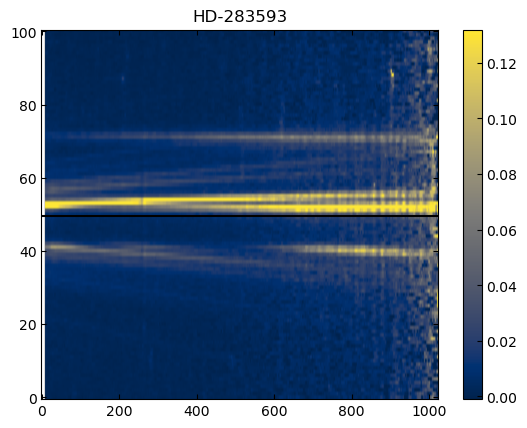

In [14]:
obs = observations['of0i02020']
fig, ax = plt.subplots()
ax.set_title(obs.hdrs['occ'][0]['TARGNAME'])
imax = ax.imshow(obs.occ_stamp.data, **ctmisc.img_vrange(obs.occ_stamp.data))
ax.axhline(obs.occ_row - obs.occ_stamp.origin_original[1], c='k')
ax.set_aspect("auto")
fig.colorbar(imax)

In [15]:
obs.cleaned_stamp = obs.clean_stamp(obs.occ_stamp.data, 10)

In [16]:
refwl_ind = 500
scale_factor = obs.wlsol/obs.wlsol[refwl_ind]
scale_factor

<Quantity [0.68238332, 0.68301789, 0.68365246, ..., 1.33032087, 1.33095295,
           1.33158502]>

In [17]:
scaled_img = sdi_tools.rescale_img(obs.cleaned_stamp, obs.occ_stamp_center, scale_factor)
scaled_img

array([[ 7.22470970e-24, -2.41041524e-23,  9.75065379e-23, ...,
        -4.44320037e-03,  1.26796873e-02, -4.44319736e-03],
       [ 8.64662352e-24, -3.52901669e-23,  1.31939227e-22, ...,
        -4.44320037e-03,  1.26796873e-02, -4.44319736e-03],
       [ 9.69286330e-24, -3.56098787e-23,  1.63223083e-22, ...,
        -4.44320037e-03,  1.26796873e-02, -4.44319736e-03],
       ...,
       [ 6.61686909e-24, -2.43682720e-23,  8.94838676e-23, ...,
         1.42285575e-02,  1.79995076e-02,  2.63738448e-02],
       [ 5.37834483e-24, -2.14568576e-23,  7.88972861e-23, ...,
         1.42285575e-02,  1.79995076e-02,  2.63738448e-02],
       [ 6.33345360e-24, -2.26058725e-23,  8.77118175e-23, ...,
         1.42285575e-02,  1.79995076e-02,  2.63738448e-02]],
      shape=(101, 1024))

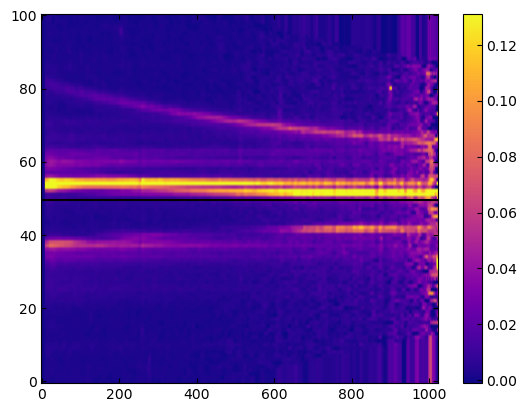

In [18]:
fig, ax = plt.subplots()
imax = ax.imshow(scaled_img, **ctmisc.img_vrange(scaled_img), cmap='plasma')
ax.axhline(obs.occ_stamp_center, c='k')

ax.set_aspect("auto")
fig.colorbar(imax)

## Plot the speckle spectra

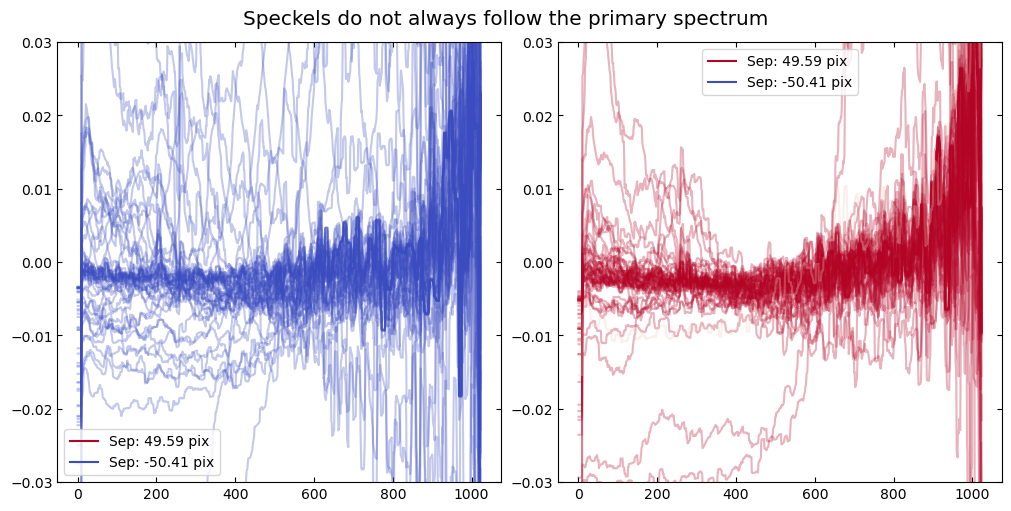

In [20]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 5), layout='constrained')
rows = np.arange(scaled_img.shape[0])
row_sep = obs.occ_stamp_center - np.arange(scaled_img.shape[0])
colors = mpl.cm.coolwarm(row_sep)

fig.suptitle("Speckels do not always follow the primary spectrum")

ax = axes[0]
for i, (row, c) in enumerate(zip(scaled_img[row_sep <= 0], colors[row_sep <= 0])):
    ax.plot(row-np.nanmean(row), c=c, alpha=0.3);

ax = axes[1]
for i, (row, c) in enumerate(zip(scaled_img[row_sep >= 0], colors[row_sep >= 0])):
    ax.plot(row-np.nanmean(row), c=c, alpha=0.3);

for ax in axes.flat:
    ax.plot([], c=colors[0], label=f'Sep: {row_sep[0]:0.2f} pix')
    ax.plot([], c=colors[-1], label=f'Sep: {row_sep[-1]:0.2f} pix')
    # line = ax.twinx().plot(obs.primary_spectrum/obs.primary_spectrum.sum(), c='k', label='Primary spectrum')
    # ax.plot([], c=line[0].get_color(), label=line[0].get_label())
    
    ax.legend()
    ax.set_ylim(-0.03, 0.03)

The speckles don't sufficiently follow the primary spectrum that we could use the primary spectrum to replace the masked value

## Let's visualize the masking and interpolation process a little better

## Mask just one row

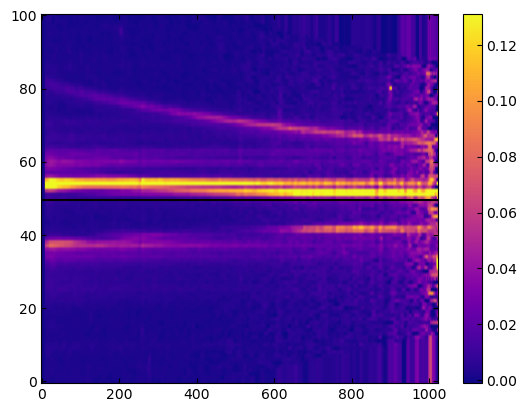

In [21]:
fig, ax = plt.subplots()
imax = ax.imshow(scaled_img, **ctmisc.img_vrange(scaled_img), cmap='plasma')
ax.axhline(obs.occ_stamp_center, c='k')

ax.set_aspect("auto")
fig.colorbar(imax)

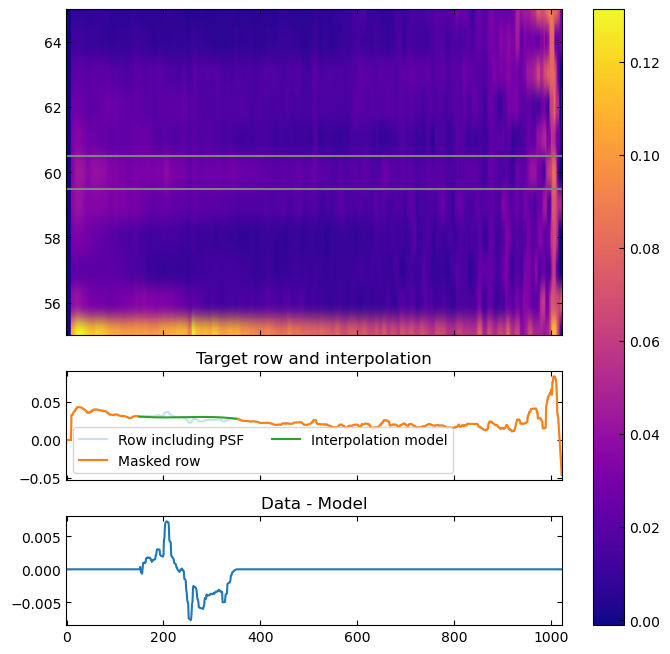

In [22]:
row = 60
fig, axes = plt.subplots(nrows=3,ncols=1, height_ratios=(3, 1, 1), sharex=True, figsize=(8, 8))
ax = axes[0]
imax = ax.imshow(scaled_img, **ctmisc.img_vrange(scaled_img), cmap='plasma')
ax.set_ylim(row-5, row+5)
ax.set_aspect("auto")
fig.colorbar(imax, ax=axes)
ax.axhline(row-0.5, c='gray')
ax.axhline(row+0.5, c='gray')

ax = axes[1]
ax.set_title("Target row and interpolation")
ax.plot(scaled_img[row], alpha=0.23, label='Row including PSF')

mask_col = 250
mask = np.zeros(scaled_img.shape[1]).astype(bool)
mask[mask_col-100:mask_col+101] = True
masked_row = np.ma.masked_array(scaled_img[row], mask=mask)
ax.plot(masked_row, label='Masked row')
# interpolate the PSF for the masked row
cols = np.arange(masked_row.size)
interp_row = interpolate.Akima1DInterpolator(
    cols[~masked_row.mask],
    masked_row[~masked_row.mask], 
    1,
)(cols)
ax.plot(cols[masked_row.mask], interp_row[masked_row.mask], label='Interpolation model')
ax.legend(ncols=2)

ax = axes[2]
ax.set_title("Data - Model")
ax.plot(masked_row.data - interp_row[cols])
# for col in np.arange(100, scaled_img.shape[1]-100):
#     mask_lb = max([0, col-100])
#     mask_ub = min([scaled_img.shape[1], col+101])
#     mask = np.zeros(scaled_img.shape[1]).astype(bool)
#     mask[mask_lb:mask_ub] = True
#     masked_row = np.ma.masked_array(scaled_img[row], mask=mask)
#     x = np.arange(img.shape[1])
#     interp_func = interp_psf.interpolate.CubicSpline(
#         x[~masked_row.mask],
#         masked_row[~masked_row.mask], 
#     )
#     interp_row[col] = interp_func(col)
# ax.plot(interp_row)

The problem is that we need to be able to predict the position of the source in the target row to know where to mask.

The PSF row-crossing column depends on two parameters:
- the initial separation of the source
- the reference wavelength used for scaling

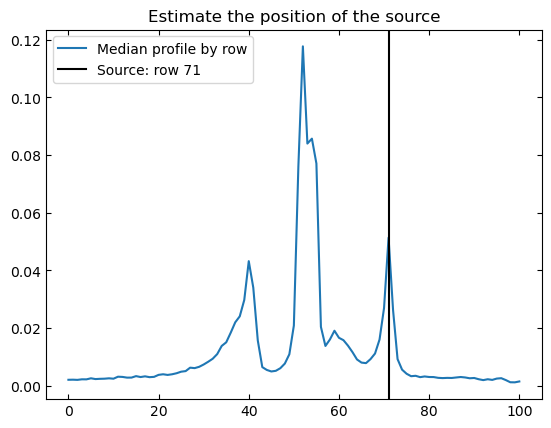

In [23]:
fig, ax = plt.subplots()
ax.set_title("Estimate the position of the source")
ax.plot(np.median(obs.cleaned_stamp, axis=1), label='Median profile by row')
# the source is somewhere between columns 65 and 80
source_row = np.argmax(np.median(obs.cleaned_stamp[65:80], axis=1))+65
ax.axvline(source_row, c='k', label=f"Source: row {source_row}")
ax.legend()
# ax.set_xlim(60, 80)

In [24]:
from importlib import reload
reload(sdi_tools)

<module 'coronspec_tools.sdi_tools' from '/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/sdi_tools.py'>

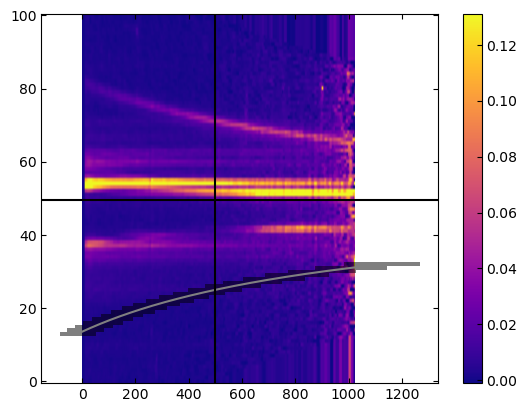

In [53]:
tmp_row = 25#source_row

fig, ax = plt.subplots()
imax = ax.imshow(scaled_img, **ctmisc.img_vrange(scaled_img), cmap='plasma')
ax.axhline(obs.occ_stamp_center, c='k')
ax.set_aspect("auto")

cols = np.arange(scaled_img.shape[1])
psf_scaled_y = sdi_tools.calc_scaled_psf_row(tmp_row, obs.occ_stamp_center, 1/scale_factor)
ax.plot(np.arange(scaled_img.shape[1]), psf_scaled_y, c='gray')

# let's calculate a bunch of masks
unique_rows = np.arange(np.floor(psf_scaled_y.min()), np.ceil(psf_scaled_y.max())+1, dtype=int)
for row_ind in unique_rows:
    mask_center, mask_width = sdi_tools.calc_wl_mask_position(
        tmp_row, row_ind, obs.occ_stamp_center, 5, obs.wlsol.to(units.Angstrom).value, refwl_ind, obs.hdrs['occ']['sci']['CD1_1']
    )
    mask = mpl.patches.Rectangle((mask_center-mask_width/2, row_ind-0.5), mask_width, 1, alpha=0.5, fc='k')
    ax.add_patch(mask)
    # ax.scatter(mask_center, row_ind, c='k')
ax.axvline(refwl_ind, c='k')
fig.colorbar(imax)

Ok great, we can predict where the mask should fall!

For a source at a given row:
1. Compute the scaled row for each column
2. For each integer scaled row value:
    1. Compute the crossing column and mask width
    2. mask the pixels under the psf
    3. generate an interpolation function for the rest of the row
    4. replace the masked pixels by their interpolated values
3. Use Step 2 to make a PSF model
4. Subtract the PSF model from the original data

In [26]:
cols = np.arange(obs.occ_stamp.data.shape[1])
scaled_rows = sdi_tools.calc_scaled_psf_row(source_row, obs.occ_stamp_center, 1/scale_factor)
scaled_rows

<Quantity [80.96566117, 80.9365104 , 80.90741351, ..., 65.68368357,
           65.67604019, 65.66840419]>

In [27]:
unique_rows = np.arange(np.floor(scaled_rows.min()), np.ceil(scaled_rows.max()), dtype=int)
unique_rows

array([65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

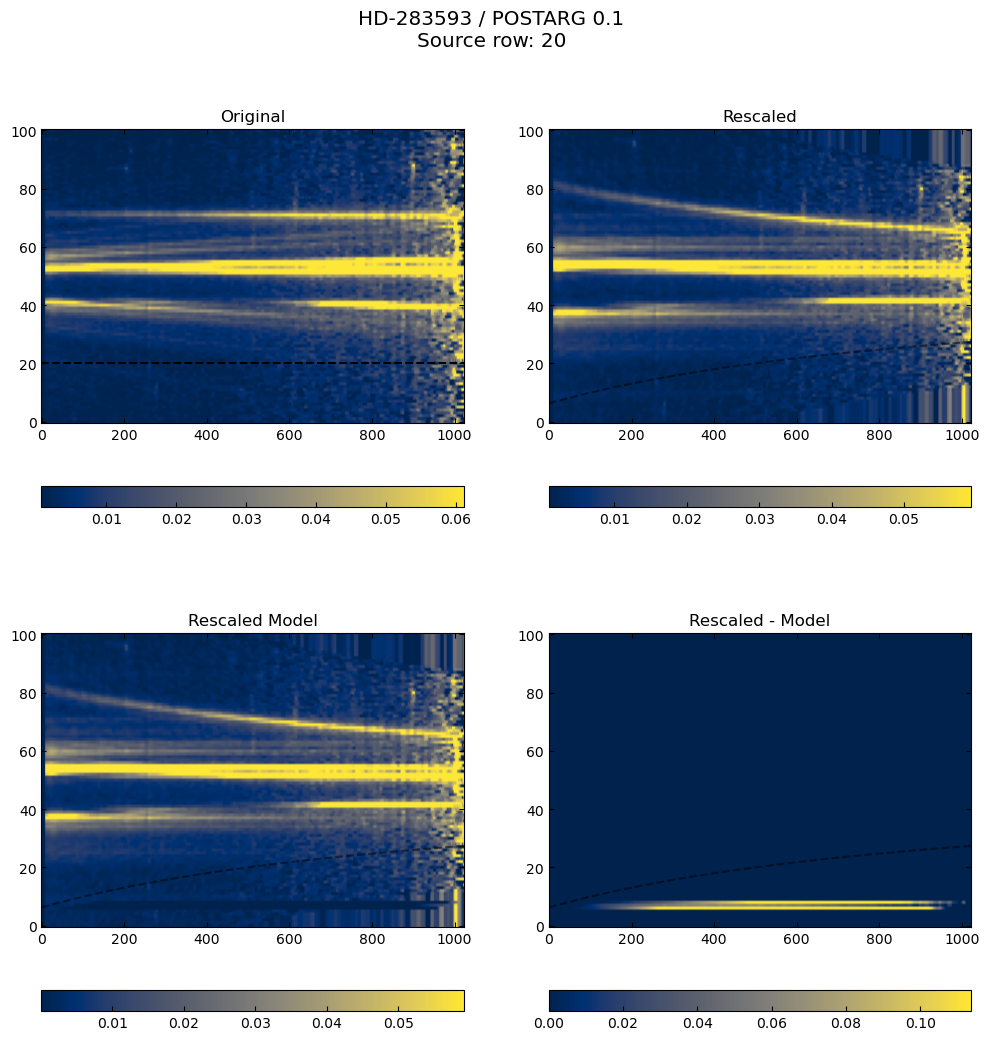

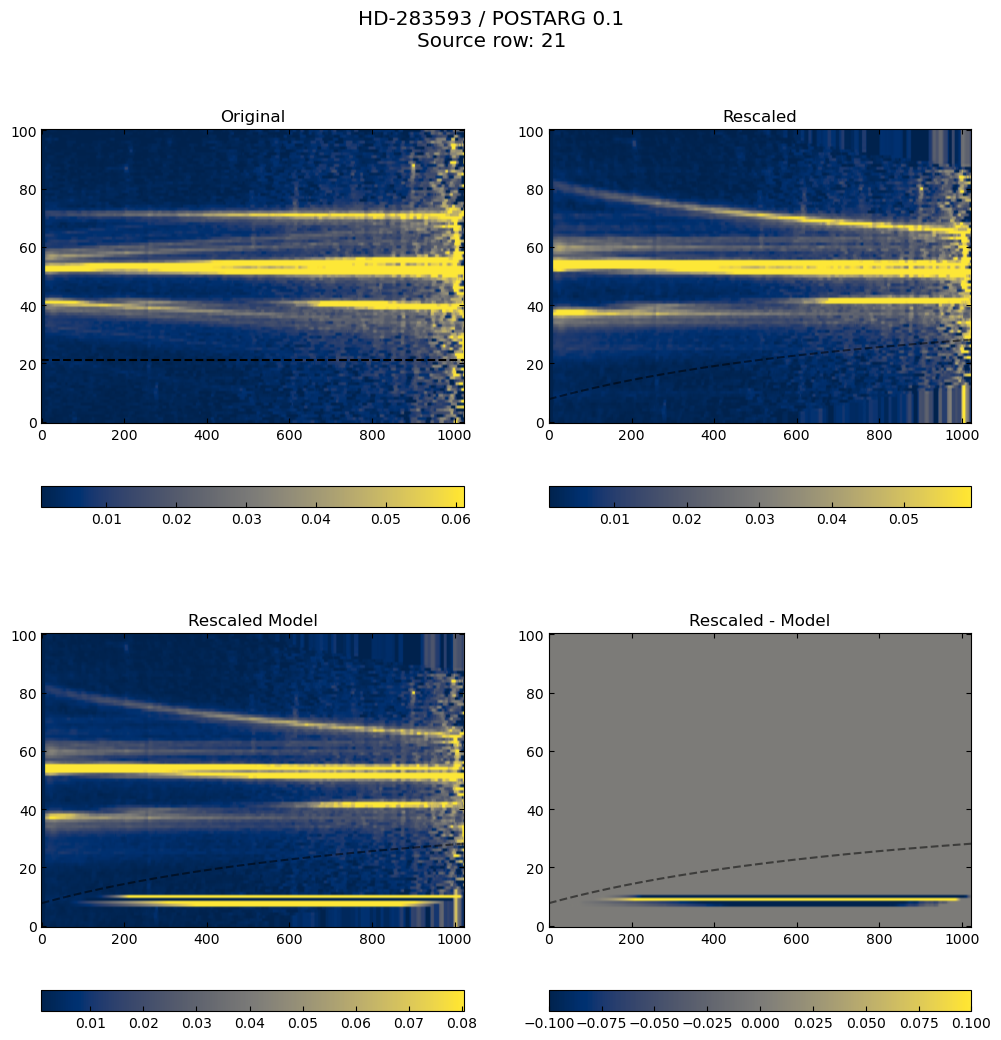

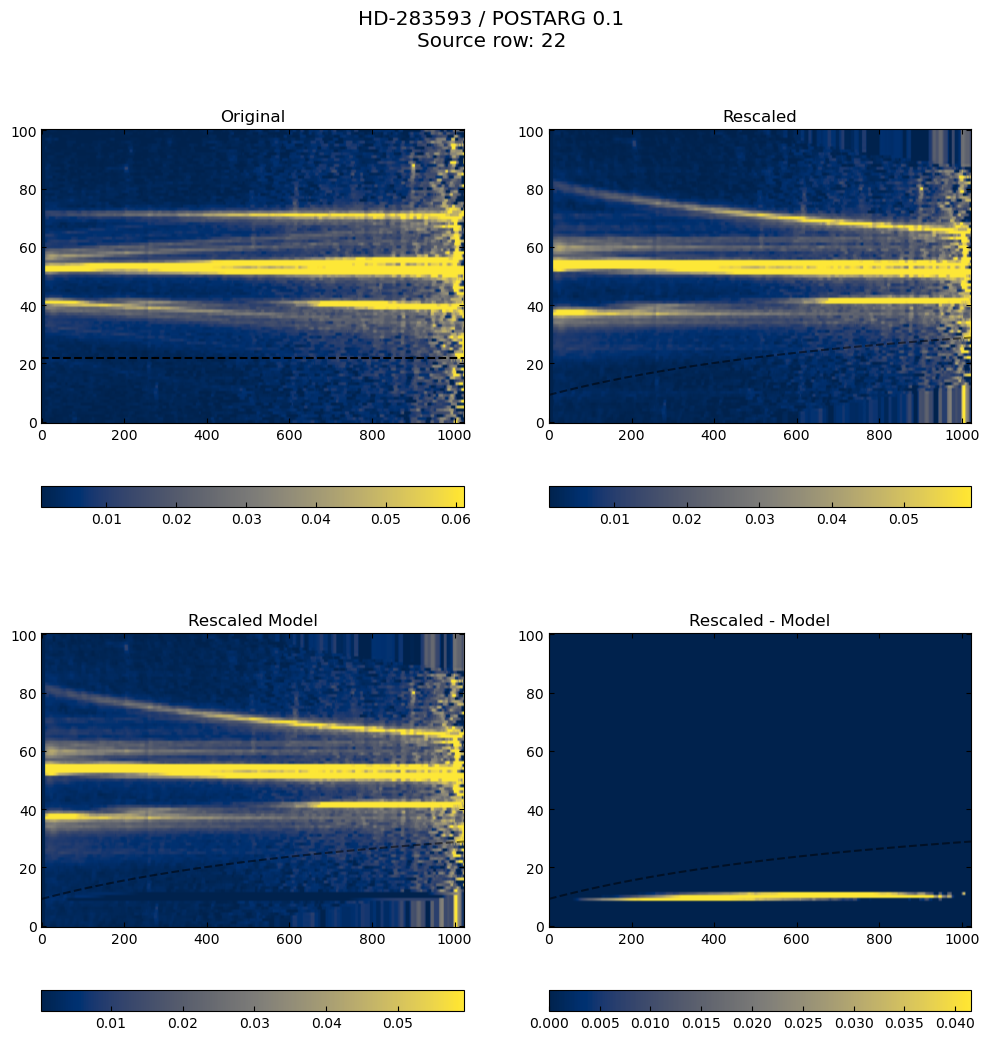

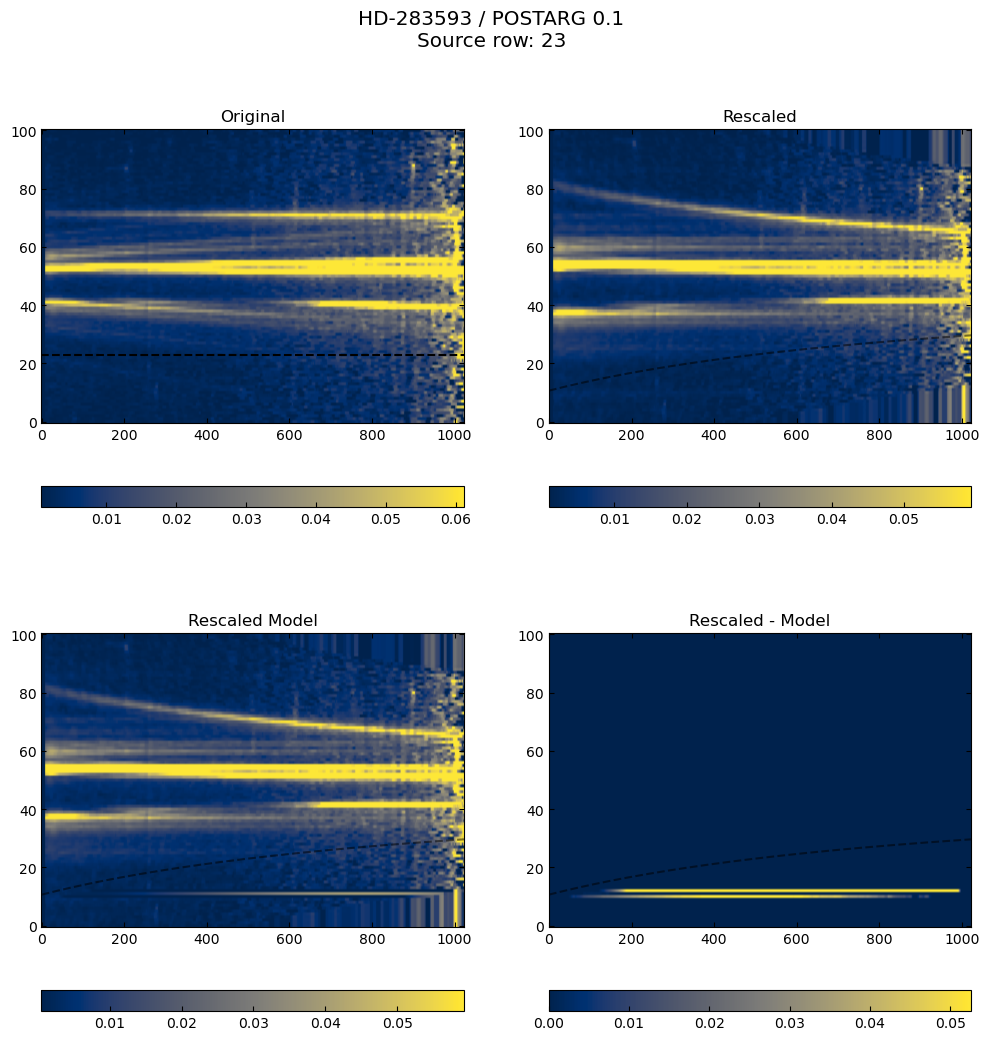

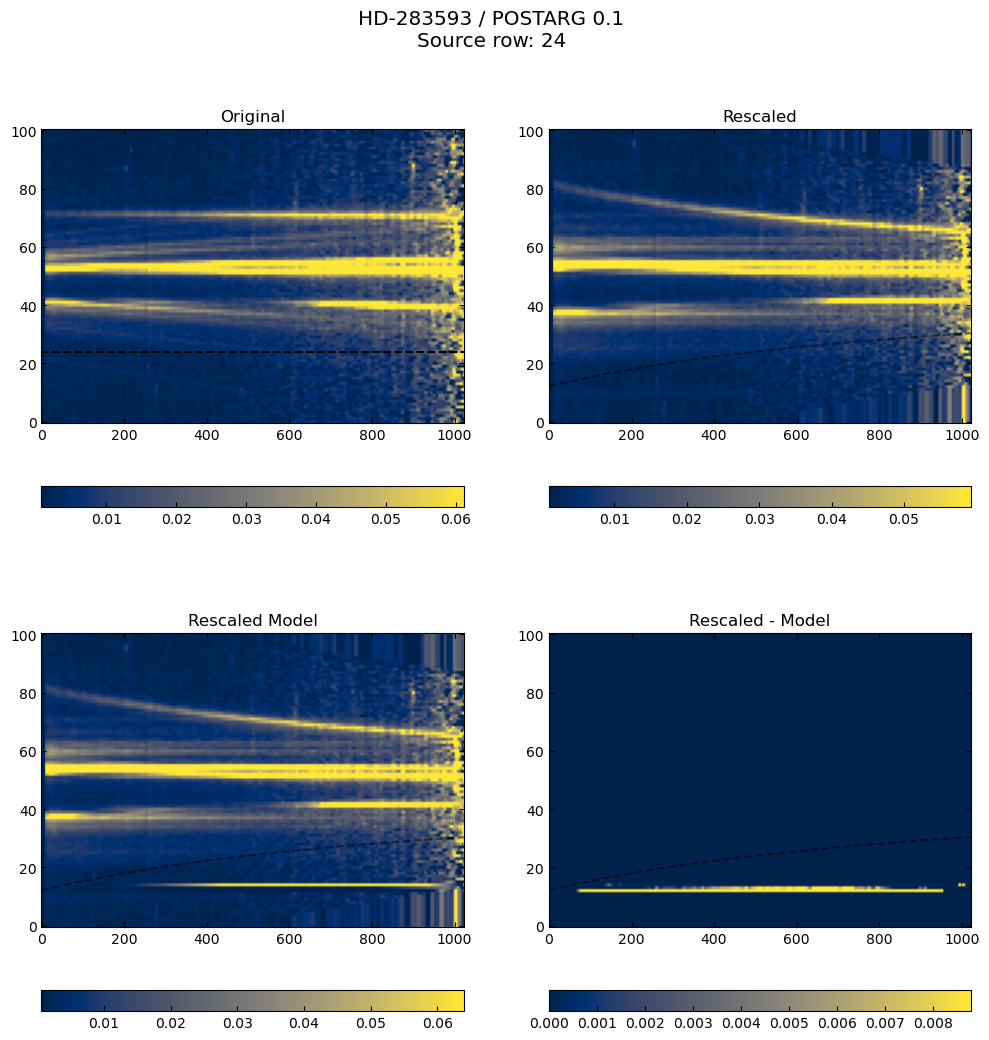

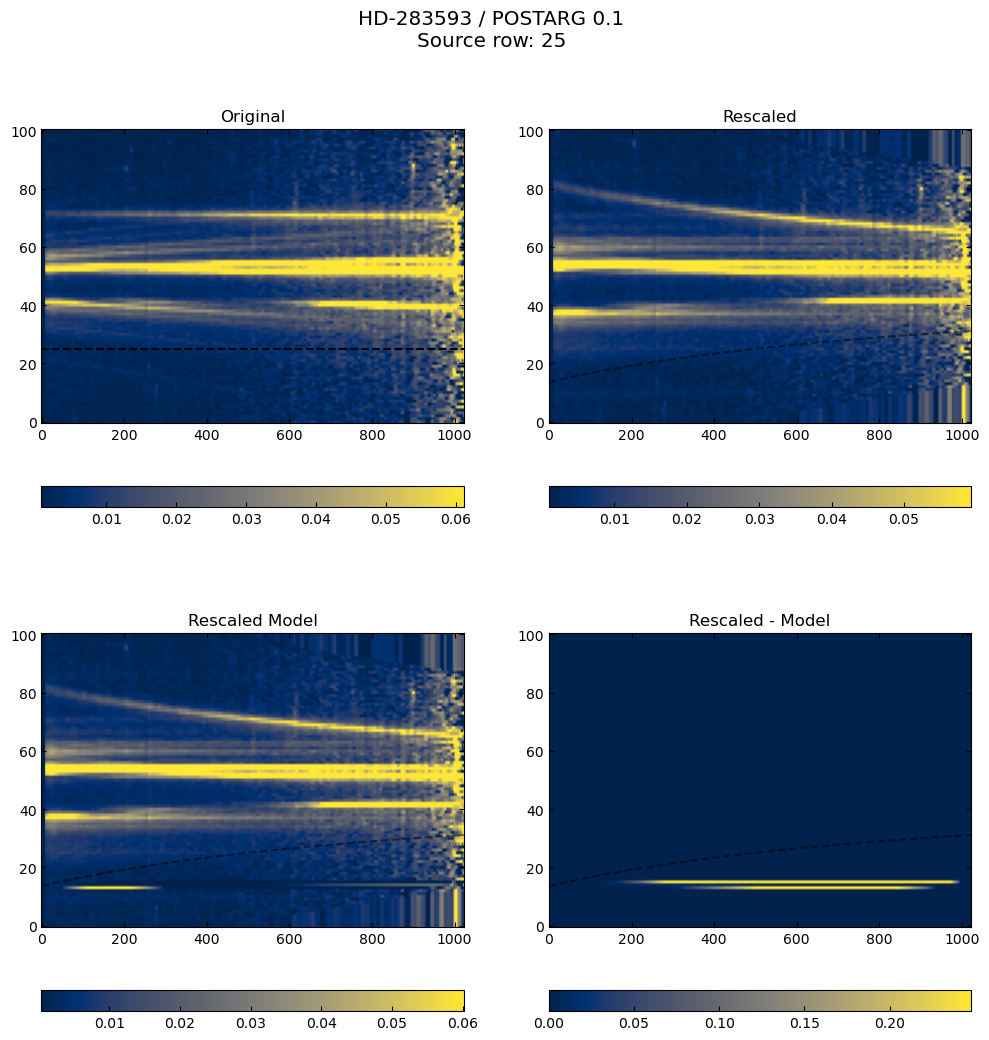

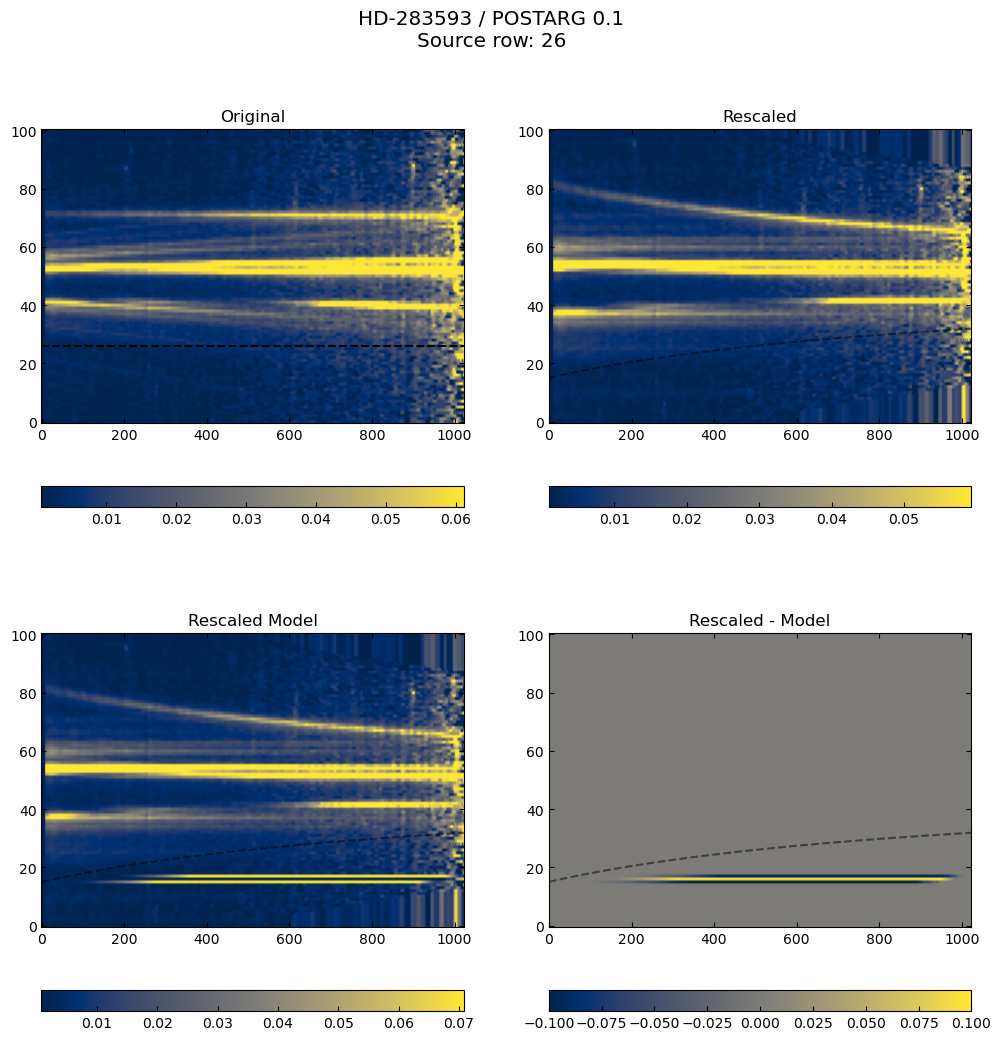

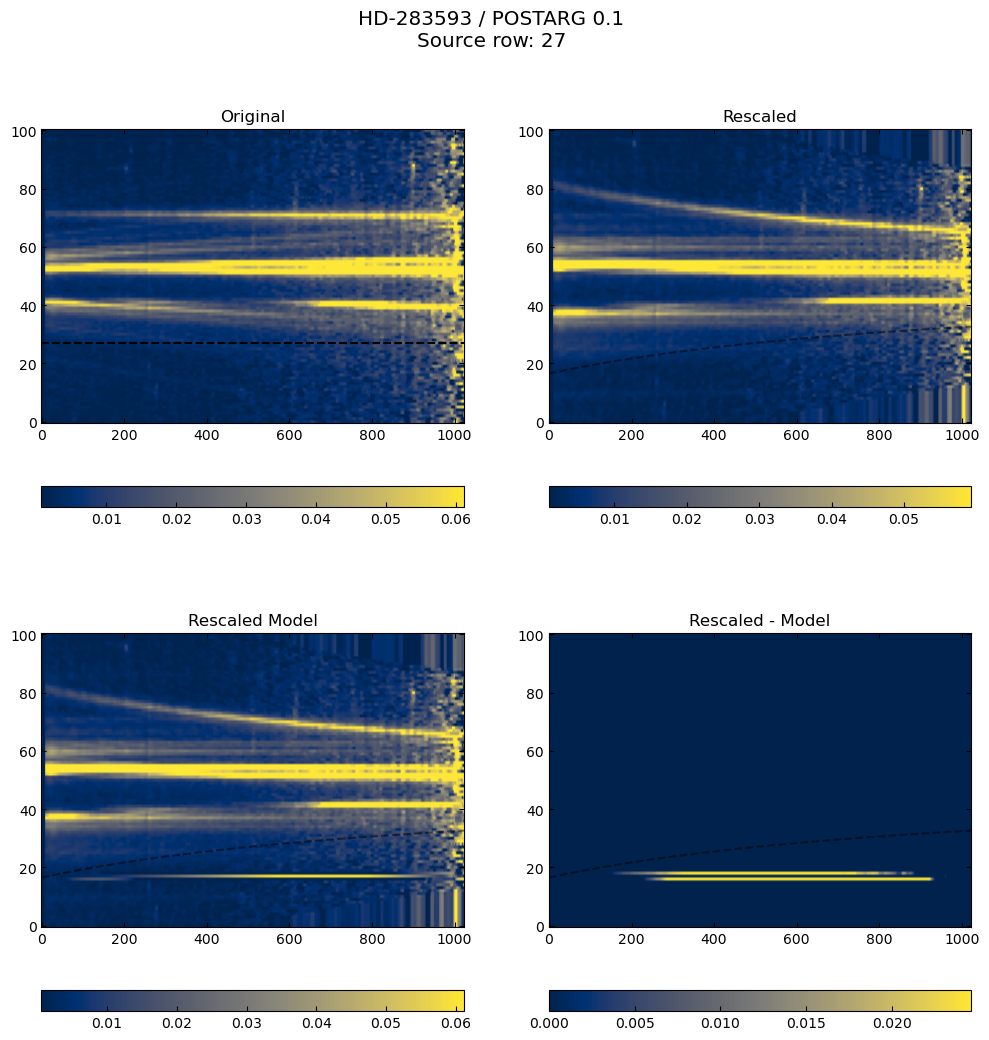

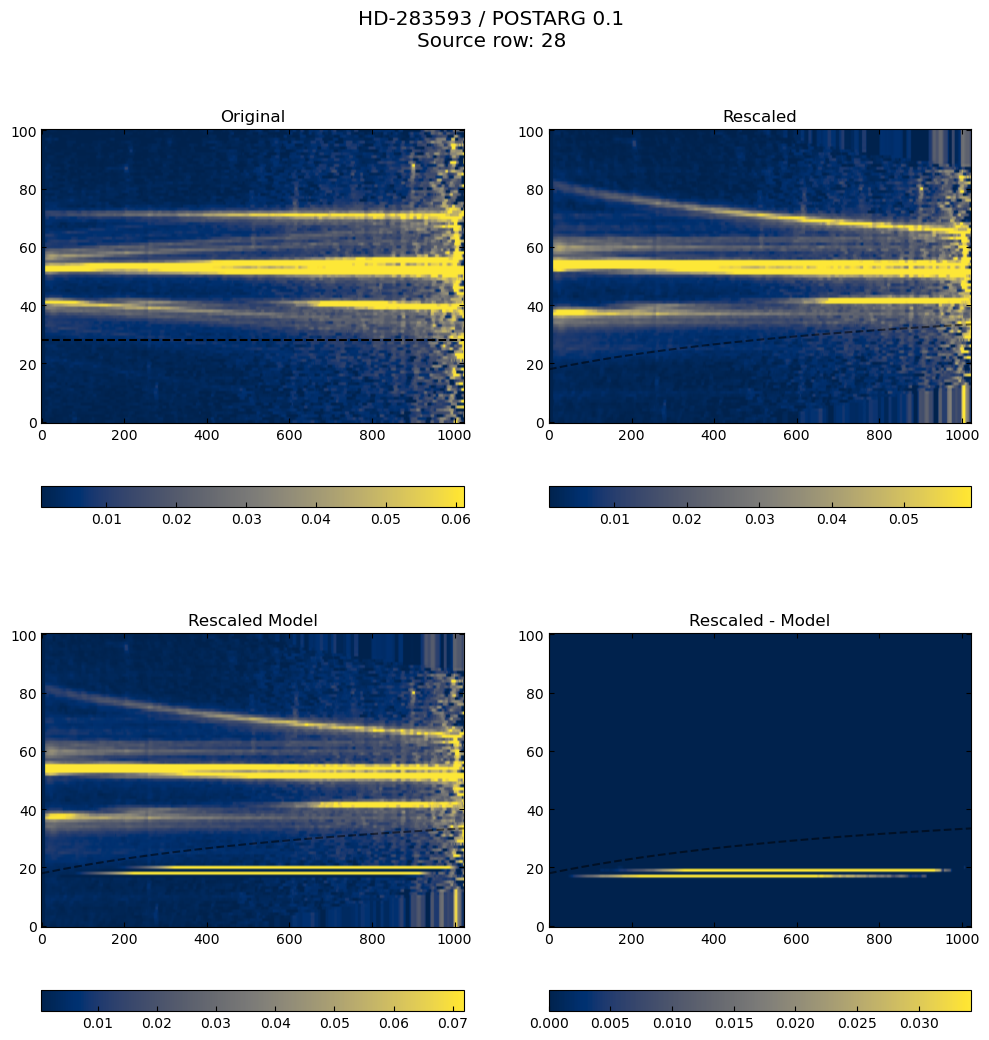

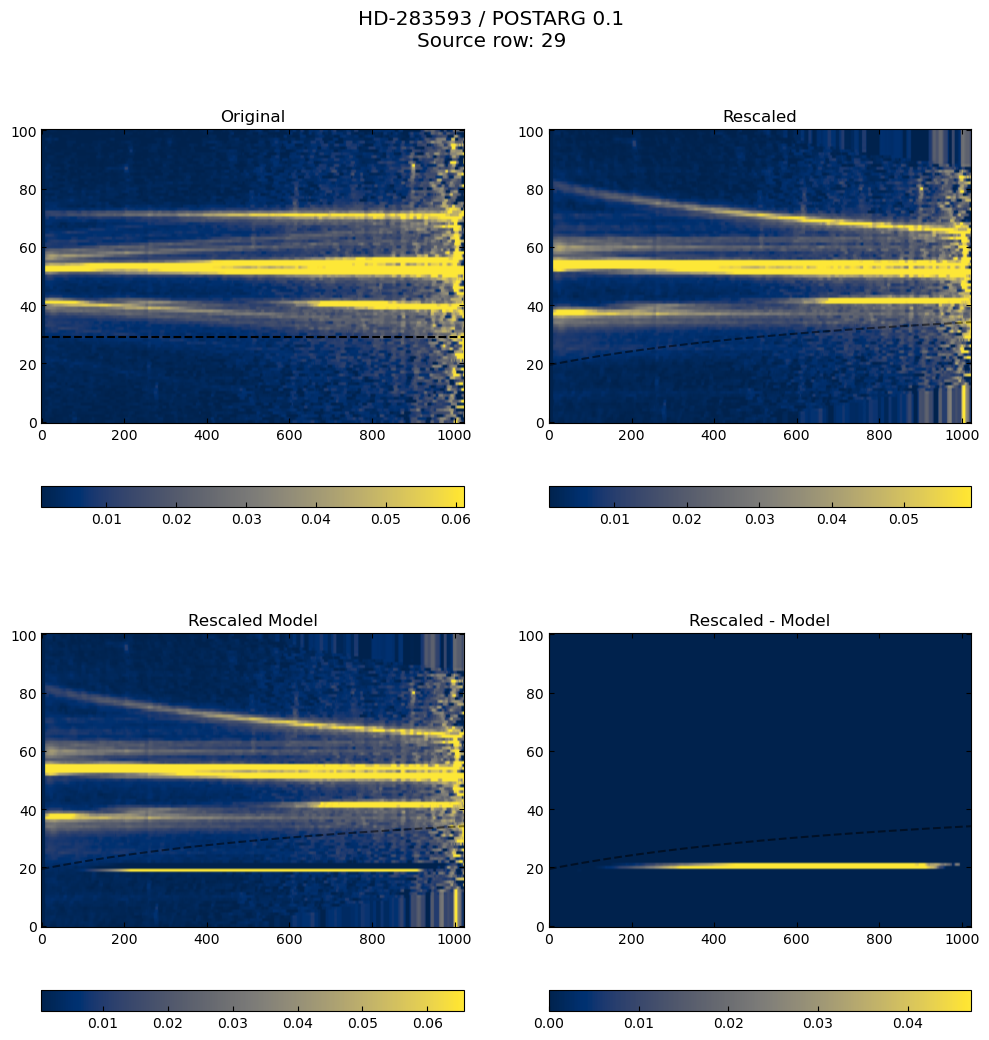

In [49]:
for source_row in range(20, 30):
    col_inds = np.arange(scaled_img.shape[1])
    psf_model = scaled_img.copy()
    scaled_rows = sdi_tools.calc_scaled_psf_row(source_row, obs.occ_stamp_center, 1/scale_factor)
    unique_rows = np.arange(np.floor(scaled_rows.min()), np.ceil(scaled_rows.max()), dtype=int)
    for row_ind in unique_rows:
        mask_center, mask_width = sdi_tools.calc_wl_mask_position(
            source_row,
            row_ind, 
            obs.occ_stamp_center, 
            5, 
            obs.wlsol.to(units.Angstrom).value, 
            refwl_ind, 
            obs.hdrs['occ']['sci']['CD1_1']
        )
        mask_range = np.round([mask_center-mask_width/2, mask_center+mask_width/2]).astype(int)
        mask = np.zeros(scaled_img.shape[1]).astype(bool)
        mask[mask_range[0]:mask_range[1]] = True    
        masked_row = np.ma.masked_array(scaled_img[row_ind], mask=mask)
        interp_row = interpolate.CubicSpline(
                col_inds[~masked_row.mask],
                masked_row[~masked_row.mask], 
            )(col_inds)
        psf_model[row_ind] = interp_row
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    fig.suptitle(f"{obs.hdrs['occ'][0]['TARGNAME']} / POSTARG {obs.hdrs['occ'][0]['POSTARG2']}\nSource row: {source_row}")
    ax = axes[0, 0]
    ax.set_title("Original")
    imax = ax.imshow(obs.cleaned_stamp, **ctmisc.img_vrange(obs.cleaned_stamp, 0.05, 0.95), aspect='auto')
    fig.colorbar(imax, ax=ax, orientation='horizontal')
    ax.axhline(source_row, c='k', ls='--')
    
    ax = axes[0, 1]
    ax.set_title("Rescaled")
    imax = ax.imshow(scaled_img, **ctmisc.img_vrange(scaled_img, 0.05, 0.95), aspect='auto')
    fig.colorbar(imax, ax=ax, orientation='horizontal')
    
    ax = axes[1, 0]
    ax.set_title("Rescaled Model")
    imax = ax.imshow(psf_model, **ctmisc.img_vrange(psf_model, 0.05, 0.95), aspect='auto')
    fig.colorbar(imax, ax=ax, orientation='horizontal')
    
    ax = axes[1, 1]
    ax.set_title("Rescaled - Model")
    diff = scaled_img - psf_model
    imax = ax.imshow(diff, **ctmisc.img_vrange(diff, 0.05, 0.99), aspect='auto')
    fig.colorbar(imax, ax=ax, orientation='horizontal')
    
    for ax in axes.ravel()[1:]:
        ax.plot(np.arange(scaled_rows.size), scaled_rows, c='k', ls='--', alpha=0.5)

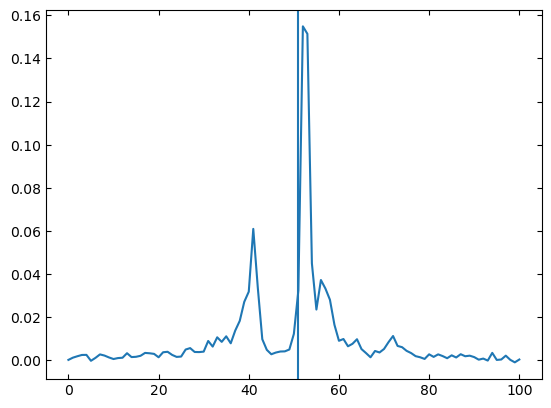

In [29]:
plt.plot(obs.occ_stamp.data[:, 10])
plt.axvline(51)

In [30]:
reload(sdi_tools)

<module 'coronspec_tools.sdi_tools' from '/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/sdi_tools.py'>

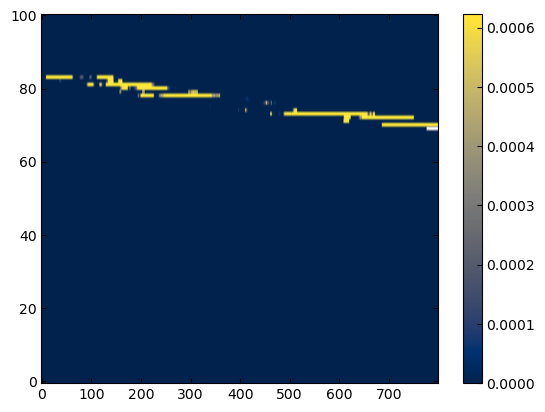

In [31]:
residuals = sdi_tools.model_and_subtract_target(
    scaled_img, obs, source_row, obs.occ_stamp_center, wl_ref_ind=refwl_ind
)
plt.imshow(residuals[:, :800], aspect='auto', **ctmisc.img_vrange(residuals[:, :800], 0.05, 0.99))
plt.colorbar()

In [32]:
row_residuals = {}
rows = np.arange(20, 81)
for row_ind in rows:
    try:
        residual = sdi_tools.model_and_subtract_target(
            scaled_img, obs, row_ind, obs.occ_stamp_center, wl_ref_ind=refwl_ind
        )
    except ValueError:
        print(f"{row_ind}: 0")
        row_residuals[row_ind] = np.zeros(scaled_img.shape[1])
    else:
        row_residuals[row_ind] = sdi_tools.descale_signal(
            residual,
            row_ind,
            obs.occ_stamp_center,
            obs.wlsol[refwl_ind]/obs.wlsol,
        )

/Users/jaguilar/Projects/miniconda3/envs/stiscoron/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/sdi_tools.py:193: RuntimeWarning: invalid value encountered in multiply
  signal[c] = np.sum(residual_img[[r_lo,r_hi], c]*weights) / np.sum(weights)


50: 0
51: 0


/Users/jaguilar/Projects/Research/hst17092-stis_coron/coronspec_tools/src/coronspec_tools/sdi_tools.py:193: RuntimeWarning: invalid value encountered in scalar divide
  signal[c] = np.sum(residual_img[[r_lo,r_hi], c]*weights) / np.sum(weights)


/var/folders/hr/1pqv7tg94gvbhpcgq7c2fb_r0001bw/T/ipykernel_94453/2435798988.py:29: RuntimeWarning: All-NaN slice encountered
  avg_signal = np.array([np.nanmedian(row[row!=0]) for row in descaled_residual])
/Users/jaguilar/Projects/miniconda3/envs/stiscoron/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jaguilar/Projects/miniconda3/envs/stiscoron/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/hr/1pqv7tg94gvbhpcgq7c2fb_r0001bw/T/ipykernel_94453/2435798988.py:31: RuntimeWarning: divide by zero encountered in divide
  snrmap = descaled_residual / err[:, None]
/var/folders/hr/1pqv7tg94gvbhpcgq7c2fb_r0001bw/T/ipykernel_94453/2435798988.py:31: RuntimeWarning: invalid value encountered in divide
  snrmap = descaled_residual / err[:

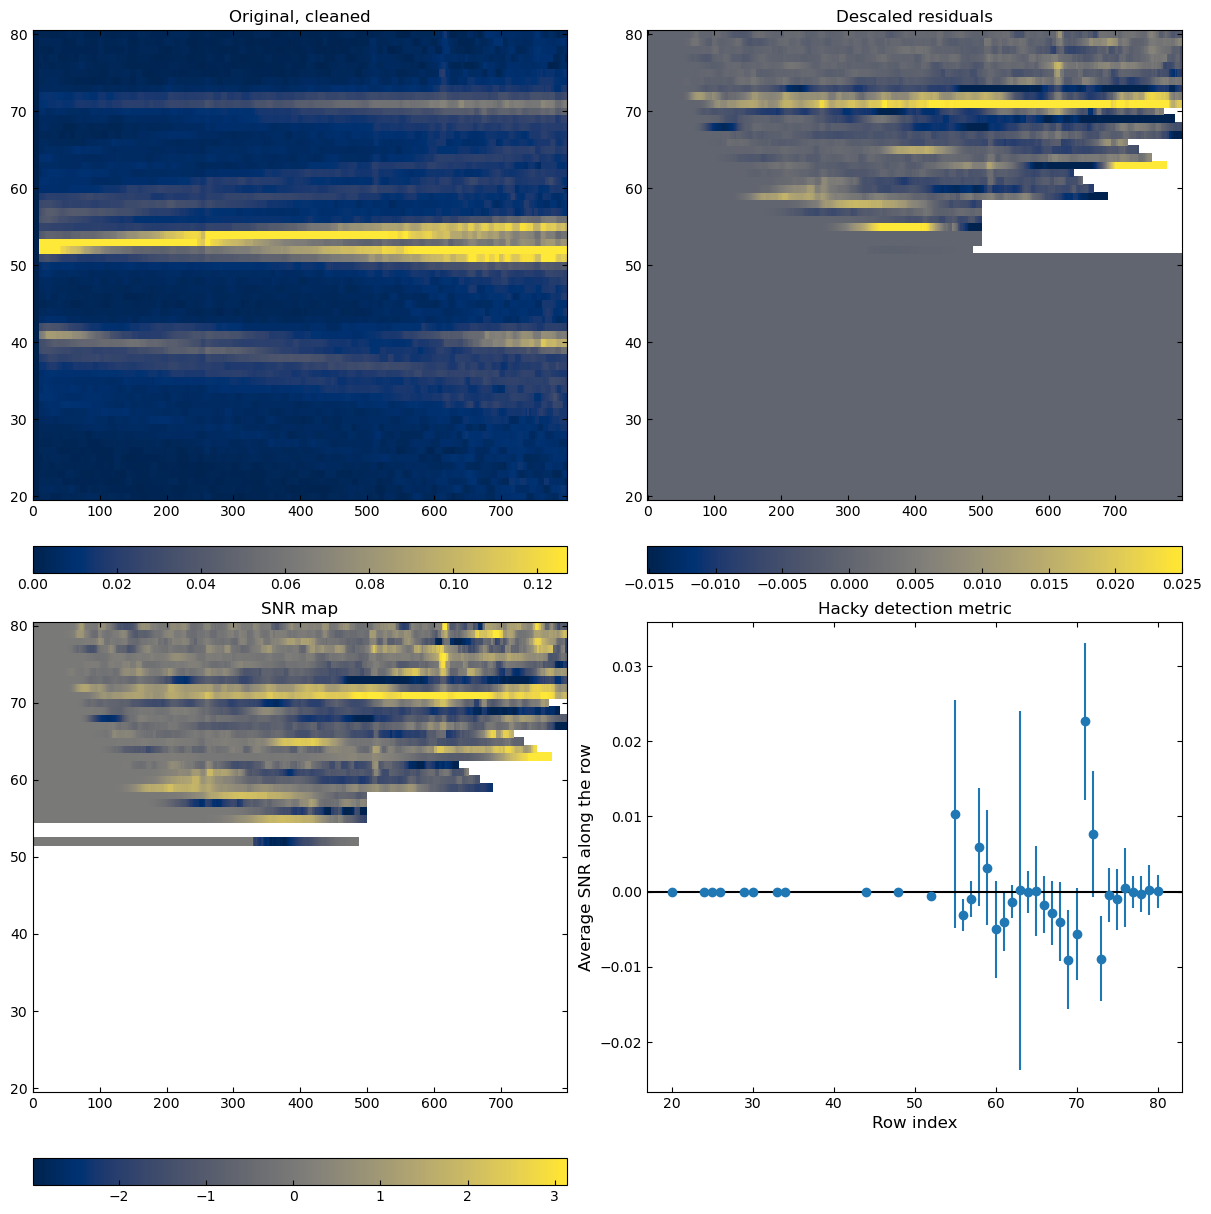

In [33]:
descaled_residual = np.stack(pd.Series(row_residuals).values)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), layout='constrained')

cols = np.arange(800)
x = np.arange(cols[0]-0.5, cols[-1]+1.5),
y = np.arange(rows.min(), rows.max()+2)-0.5

ax = axes[0, 0]
ax.set_title("Original, cleaned")
imax = ax.pcolor(
    x, y,
    obs.cleaned_stamp[rows, :cols.size],
    **ctmisc.img_vrange(obs.cleaned_stamp[:, :cols.size])
)
fig.colorbar(imax, ax=ax, orientation='horizontal')

ax = axes[0, 1]
ax.set_title("Descaled residuals")
imax = ax.pcolor(
    x, y,
    descaled_residual[:, :cols.size], 
    **ctmisc.img_vrange(descaled_residual[:, :cols.size]),
)
fig.colorbar(imax, ax=ax, orientation='horizontal')


ax = axes[1, 0]

avg_signal = np.array([np.nanmedian(row[row!=0]) for row in descaled_residual])
err = np.array([np.nanstd(row[row!=0]) for row in descaled_residual])
snrmap = descaled_residual / err[:, None]

ax.set_title("SNR map")
imax = ax.pcolor(
    x, y,
    snrmap[:, :cols.size], 
    **ctmisc.img_vrange(snrmap[:, :cols.size]),
)
fig.colorbar(imax, ax=ax, orientation='horizontal')

ax = axes[1, 1]
ax.set_title("Hacky detection metric")
ax.set_xlabel("Row index")
ax.set_ylabel("Average SNR along the row")
ax.errorbar(rows, avg_signal, yerr=err, ls='none', marker='o')
ax.axhline(0, c='k')

In [34]:
descaled_residual.shape

(61, 1024)

In [35]:
descaled_residual[np.nanargmax(avg_signal), :] 

array([ 0.,  0.,  0., ..., nan, nan, nan], shape=(1024,))

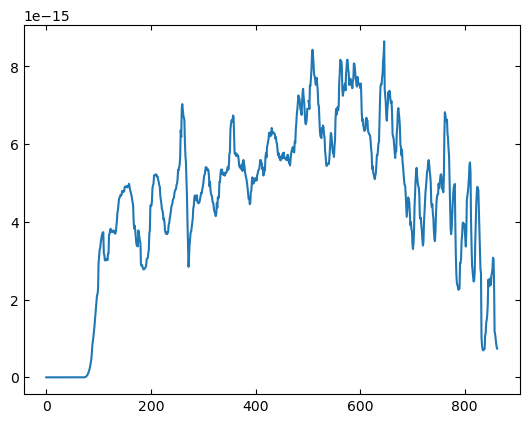

In [44]:
fig, ax = plt.subplots(1, 1)
ax.plot(
    np.arange(descaled_residual.shape[1]), 
    descaled_residual[np.nanargmax(avg_signal), :] * obs.primary_spectrum_flux
)

/var/folders/hr/1pqv7tg94gvbhpcgq7c2fb_r0001bw/T/ipykernel_94453/2057806845.py:1: RuntimeWarning: Mean of empty slice
  stdmap = np.array([np.nanmean(col[col!=0]) for col in descaled_residual])


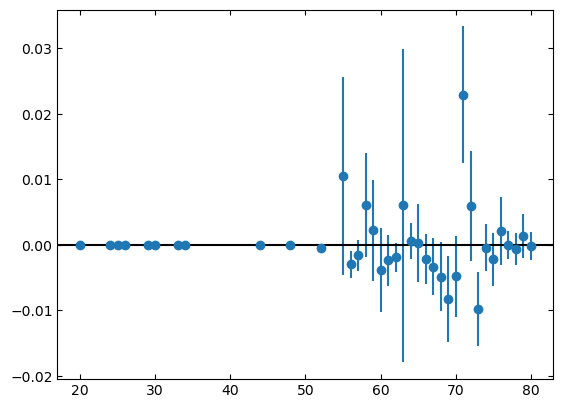

In [45]:
stdmap = np.array([np.nanmean(col[col!=0]) for col in descaled_residual])
err = np.array([np.nanstd(col[col!=0]) for col in descaled_residual])
plt.errorbar(rows, stdmap, yerr=err, ls='none', marker='o')
plt.axhline(0, c='k')